In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
import random
words = open('Indian_Names.txt', 'r').read().splitlines()

random.shuffle(words)
words = [w.lower() for w in words]
words[:8]

['mishty',
 'mathev',
 'taru',
 'sabishan',
 'madhushree',
 'shrilesh',
 'veerajeyen',
 'ovyaa']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([390892, 3]) torch.Size([390892])
torch.Size([48542, 3]) torch.Size([48542])
torch.Size([48640, 3]) torch.Size([48640])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #* 0.2 #kaiming init for non-linearity
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [16]:
(torch.randn(10000) * 0.2).std()

tensor(0.2009)

tensor(-0.0103) tensor(0.9933)
tensor(0.0002) tensor(0.9791)


(array([1.95247603e-05, 1.95247603e-05, 1.95247603e-05, 0.00000000e+00,
        0.00000000e+00, 3.90495205e-05, 5.85742808e-05, 5.85742808e-05,
        1.17148562e-04, 1.75722842e-04, 1.36673322e-04, 3.51445685e-04,
        9.17663732e-04, 1.67912938e-03, 2.42107027e-03, 3.70970445e-03,
        7.39988414e-03, 1.35697084e-02, 2.30392171e-02, 3.72922921e-02,
        6.24792328e-02, 9.86390888e-02, 1.44502751e-01, 2.09559252e-01,
        2.83187123e-01, 3.50567070e-01, 4.02795804e-01, 4.32610113e-01,
        4.18181315e-01, 3.78585101e-01, 3.09389351e-01, 2.40935542e-01,
        1.72501257e-01, 1.19081513e-01, 7.56974955e-02, 4.75427912e-02,
        2.87794966e-02, 1.68889176e-02, 9.46950872e-03, 5.72075476e-03,
        2.79204072e-03, 1.62055510e-03, 7.61465650e-04, 6.83366609e-04,
        3.51445685e-04, 2.73346644e-04, 1.36673322e-04, 1.36673322e-04,
        0.00000000e+00, 5.85742808e-05]),
 array([-7.09839344, -6.84230835, -6.58622326, -6.33013817, -6.07405308,
        -5.81796799, 

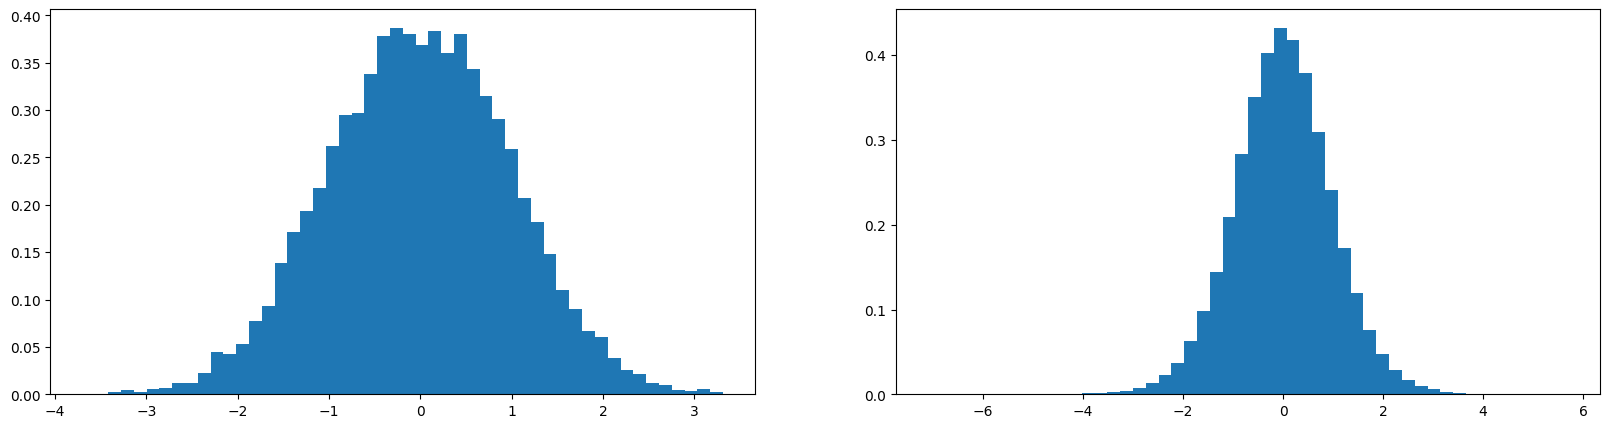

In [13]:
X = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = X @ w
print(X.mean(),X.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(),50 , density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50 , density=True)

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  



      0/ 200000: 3.2960
  10000/ 200000: 2.1936
  20000/ 200000: 1.9732
  30000/ 200000: 1.9183
  40000/ 200000: 1.8231
  50000/ 200000: 2.0285
  60000/ 200000: 2.4200
  70000/ 200000: 2.3504
  80000/ 200000: 2.1296
  90000/ 200000: 1.8368
 100000/ 200000: 2.0568
 110000/ 200000: 1.7640
 120000/ 200000: 1.6637
 130000/ 200000: 2.0983
 140000/ 200000: 1.7069
 150000/ 200000: 1.4896
 160000/ 200000: 2.0490
 170000/ 200000: 1.8989
 180000/ 200000: 1.5126
 190000/ 200000: 1.8399


In [21]:
hpreact.shape

torch.Size([32, 200])

In [23]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [24]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

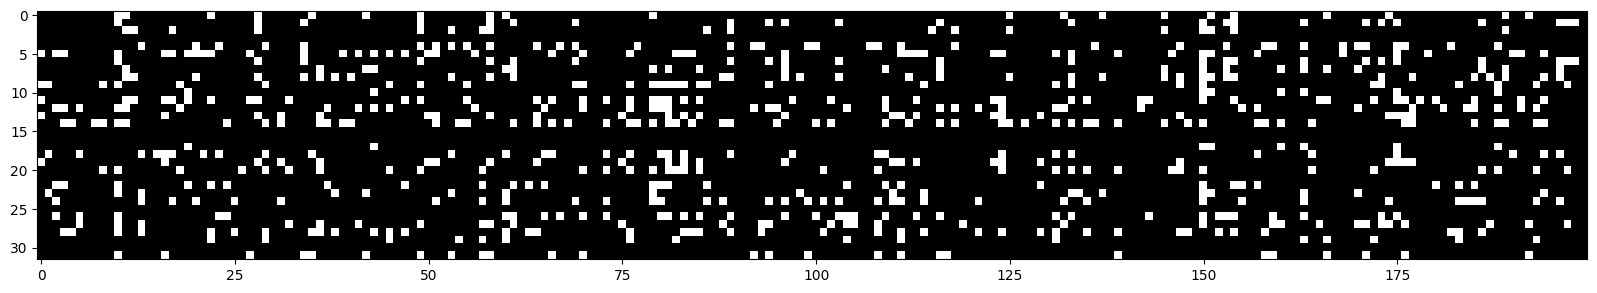

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([218., 222., 191., 175., 153., 132., 146., 111.,  96., 139., 101.,
         97., 109.,  80., 104.,  91.,  82., 105., 100., 106., 108.,  93.,
         96.,  86.,  86.,  99.,  86., 101.,  85.,  89.,  67., 117., 105.,
        108.,  93., 102., 105., 113., 130., 103., 127., 140., 142., 158.,
        152., 164., 189., 213., 241., 344.]),
 array([-9.99887943e-01, -9.59897236e-01, -9.19906528e-01, -8.79915820e-01,
        -8.39925113e-01, -7.99934405e-01, -7.59943697e-01, -7.19952990e-01,
        -6.79962282e-01, -6.39971575e-01, -5.99980867e-01, -5.59990159e-01,
        -5.19999452e-01, -4.80008744e-01, -4.40018036e-01, -4.00027329e-01,
        -3.60036621e-01, -3.20045913e-01, -2.80055206e-01, -2.40064498e-01,
        -2.00073791e-01, -1.60083083e-01, -1.20092375e-01, -8.01016676e-02,
        -4.01109600e-02, -1.20252371e-04,  3.98704553e-02,  7.98611629e-02,
         1.19851871e-01,  1.59842578e-01,  1.99833286e-01,  2.39823993e-01,
         2.79814701e-01,  3.19805409e-01,  3.59796

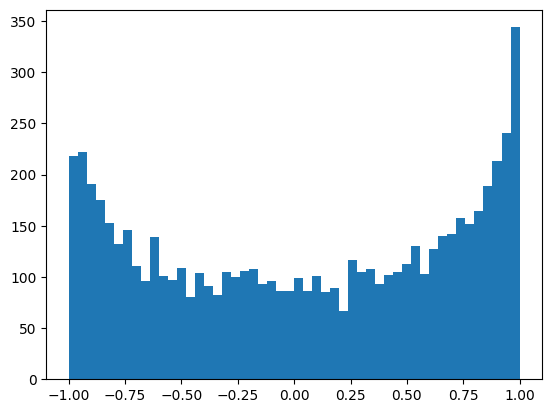

In [35]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   1.,   0.,   1.,   0.,   1.,   3.,   3.,   8.,  11.,   8.,
         22.,  23.,  34.,  48.,  54.,  90., 141., 166., 211., 234., 274.,
        309., 329., 383., 438., 421., 398., 423., 401., 347., 329., 264.,
        224., 194., 140., 109.,  98.,  72.,  56.,  39.,  28.,  21.,  17.,
          9.,   9.,   4.,   1.,   1.,   2.]),
 array([-4.89476395, -4.71043654, -4.52610914, -4.34178174, -4.15745434,
        -3.97312694, -3.78879953, -3.60447213, -3.42014473, -3.23581733,
        -3.05148993, -2.86716252, -2.68283512, -2.49850772, -2.31418032,
        -2.12985291, -1.94552551, -1.76119811, -1.57687071, -1.39254331,
        -1.2082159 , -1.0238885 , -0.8395611 , -0.6552337 , -0.4709063 ,
        -0.28657889, -0.10225149,  0.08207591,  0.26640331,  0.45073071,
         0.63505812,  0.81938552,  1.00371292,  1.18804032,  1.37236773,
         1.55669513,  1.74102253,  1.92534993,  2.10967733,  2.29400474,
         2.47833214,  2.66265954,  2.84698694,  3.03131434,  3.21564175,
 

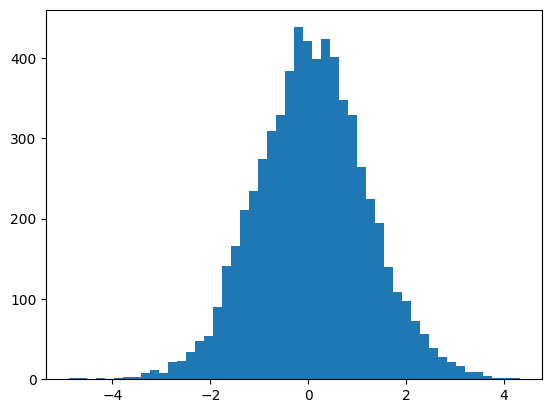

In [36]:
plt.hist(hpreact.view(-1).tolist(),50)

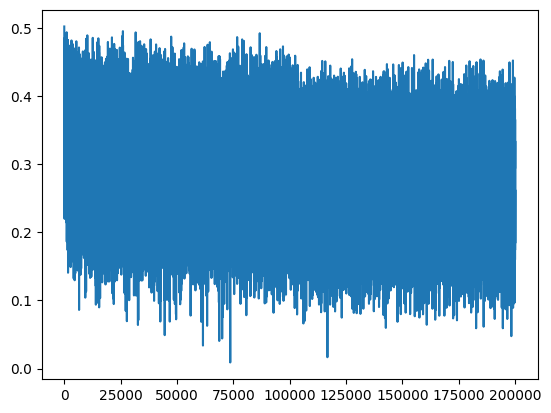

In [15]:
plt.plot(lossi)

In [33]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [34]:
bnmean

tensor([[-0.0179, -0.3813, -1.9971, -0.4468,  0.4873,  0.4159,  2.4118, -1.4266,
          0.4157,  0.5414, -1.4930, -1.9996, -0.3210,  0.4856, -0.3200,  0.3794,
          0.6332, -1.8908,  0.3621,  0.1769, -0.3409, -1.4046,  0.2940, -0.7709,
          0.9410,  0.7455,  0.5158, -0.7135,  0.2353,  1.3535, -0.6300, -0.1235,
         -0.5160,  0.3790, -0.4079, -0.0167, -0.2541,  0.0427, -0.2818,  0.6842,
         -0.1111,  0.4652, -0.0606,  0.9354,  0.7804, -0.1623,  0.2622,  0.5191,
          1.1868,  0.7332, -0.3140,  0.9626,  1.5369,  1.0022,  0.6869, -0.5522,
         -0.4221,  0.9328,  1.0415, -1.0540, -0.3028,  1.3108,  0.4922, -0.7857,
          0.7277,  0.4787,  2.3647,  0.5886, -0.9770,  0.6487, -1.0055,  0.0344,
          0.3393, -2.0962, -1.2812,  0.3358,  1.1284, -0.9234,  0.5455,  1.1086,
          0.1472,  2.2114,  1.5562, -0.1945,  0.1819, -1.1565, -0.7514,  0.5167,
          0.4899, -1.0971, -0.9349,  0.7683, -0.8516, -0.8931, -0.9598, -0.3074,
         -0.3964, -0.0417, -

In [35]:
bnmean_running

tensor([[-0.0300, -0.3806, -1.9900, -0.4294,  0.4860,  0.4318,  2.4066, -1.4288,
          0.4179,  0.5348, -1.4965, -1.9948, -0.3240,  0.4746, -0.3127,  0.3732,
          0.6317, -1.8936,  0.3718,  0.1758, -0.3320, -1.3983,  0.2883, -0.7740,
          0.9384,  0.7331,  0.5101, -0.7130,  0.2269,  1.3311, -0.6229, -0.1229,
         -0.5114,  0.3895, -0.4140, -0.0327, -0.2530,  0.0450, -0.2741,  0.6757,
         -0.1147,  0.4686, -0.0749,  0.9392,  0.7869, -0.1647,  0.2481,  0.5237,
          1.1728,  0.7198, -0.3184,  0.9609,  1.5264,  1.0039,  0.6773, -0.5533,
         -0.4193,  0.9338,  1.0476, -1.0585, -0.3084,  1.3006,  0.4939, -0.7838,
          0.7205,  0.4784,  2.3504,  0.5864, -0.9712,  0.6434, -0.9911,  0.0268,
          0.3352, -2.1170, -1.2883,  0.3416,  1.1294, -0.9169,  0.5329,  1.1164,
          0.1536,  2.2044,  1.5575, -0.2102,  0.1694, -1.1580, -0.7467,  0.5124,
          0.4846, -1.1089, -0.9323,  0.7707, -0.8587, -0.8931, -0.9629, -0.3141,
         -0.3851, -0.0513, -

In [36]:
bnstd

tensor([[2.7495, 2.1845, 2.3493, 2.1687, 1.9925, 2.4754, 2.3829, 1.9798, 1.8728,
         1.8303, 2.2643, 2.1047, 1.7943, 2.7572, 1.6306, 1.7416, 2.1915, 2.1996,
         2.4869, 1.9439, 1.8915, 2.4123, 1.7491, 2.1041, 1.8347, 2.1518, 1.9535,
         2.1692, 2.0203, 1.8845, 1.6427, 2.0317, 2.1569, 1.5321, 2.0591, 1.8210,
         2.0088, 1.5516, 2.1370, 1.8005, 1.7836, 1.8133, 2.3271, 2.1003, 2.0586,
         2.0362, 1.8505, 1.7152, 2.6294, 2.1370, 1.8031, 2.2589, 2.0221, 2.1578,
         2.3604, 2.0756, 1.7232, 1.8998, 2.3813, 2.1618, 2.0433, 2.4012, 1.8743,
         2.4441, 2.4788, 2.3201, 2.0389, 1.9249, 1.9850, 2.2934, 2.4595, 1.9710,
         1.8989, 2.0645, 1.7714, 1.7864, 1.8707, 2.3169, 1.6646, 2.3094, 1.8826,
         2.2196, 1.5604, 2.5607, 2.4272, 2.3706, 2.5165, 1.8210, 1.8996, 2.2994,
         1.8016, 1.8707, 1.6973, 2.4281, 1.6500, 1.9141, 1.9407, 2.0993, 2.2025,
         2.0979, 1.5506, 1.8258, 2.1587, 1.9345, 2.3260, 2.1229, 1.6802, 2.1502,
         2.2843, 1.9512, 2.7

In [37]:
bnstd_running

tensor([[2.7210, 2.1670, 2.3233, 2.1354, 1.9892, 2.4597, 2.3485, 1.9618, 1.8591,
         1.7972, 2.2526, 2.0797, 1.7770, 2.7521, 1.6137, 1.7166, 2.1568, 2.1890,
         2.4853, 1.9156, 1.8718, 2.3996, 1.7354, 2.0866, 1.8184, 2.1164, 1.9224,
         2.1489, 2.0070, 1.8653, 1.6222, 2.0119, 2.1243, 1.5210, 2.0392, 1.7986,
         1.9813, 1.5452, 2.1168, 1.7927, 1.7706, 1.7957, 2.3111, 2.0877, 2.0388,
         2.0158, 1.8324, 1.7028, 2.6167, 2.1108, 1.7938, 2.2455, 2.0056, 2.1395,
         2.3464, 2.0569, 1.7008, 1.8761, 2.3562, 2.1459, 2.0247, 2.3544, 1.8514,
         2.3923, 2.4496, 2.2904, 2.0282, 1.9101, 1.9679, 2.2636, 2.4378, 1.9508,
         1.8799, 2.0419, 1.7538, 1.7603, 1.8279, 2.2892, 1.6516, 2.2873, 1.8592,
         2.2222, 1.5344, 2.5539, 2.4049, 2.3434, 2.4991, 1.8002, 1.8744, 2.2770,
         1.7770, 1.8490, 1.6747, 2.4047, 1.6389, 1.8954, 1.9274, 2.0815, 2.1813,
         2.0679, 1.5340, 1.8061, 2.1208, 1.9168, 2.3053, 2.0922, 1.6681, 2.1277,
         2.2536, 1.9402, 2.7

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  # hpreact = hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9072260856628418
val 1.9243597984313965


In [39]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

charavelli.
llxith.
gruxjanth.
skandan.
frzhntradhesvithy.
qhir.
rzanrajchaiiviysneglyshnm.
friy.
qhxnt.
shoorvan.
vebi.
rajesh.
deartxika.
qukpirudhisa.
frith.
gileshant.
frajasmithr.
ksya.
frabhagzhanthyn.
friti.


# **Torchifying/Modularizing the code**

In [41]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2965


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.72%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.22%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 1.88%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.56%


Text(0.5, 1.0, 'activation distribution')

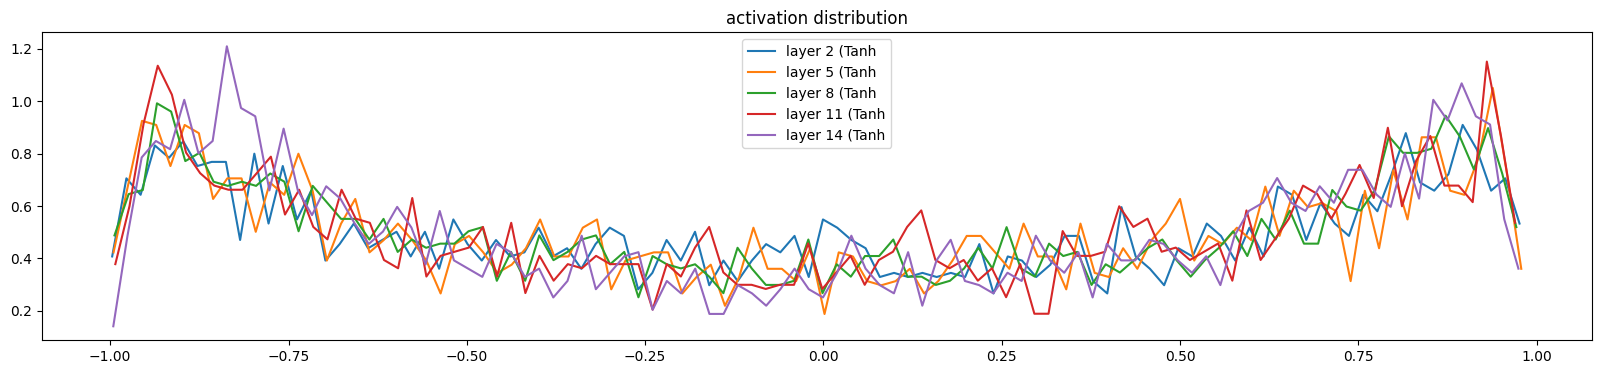

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.224321e-03
layer 5 (      Tanh): mean +0.000000, std 1.859251e-03
layer 8 (      Tanh): mean +0.000000, std 1.739388e-03
layer 11 (      Tanh): mean +0.000000, std 1.718022e-03
layer 14 (      Tanh): mean +0.000000, std 1.706402e-03


Text(0.5, 1.0, 'gradient distribution')

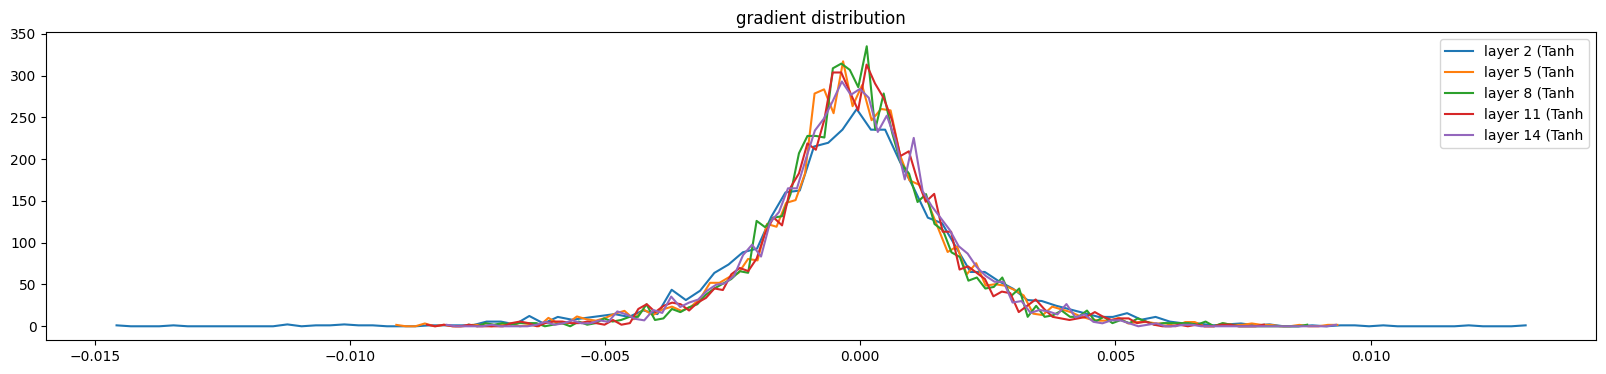

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 6.750451e-03 | grad:data ratio 6.743647e-03
weight  (30, 100) | mean +0.000259 | std 8.513688e-03 | grad:data ratio 4.491925e-02
weight (100, 100) | mean -0.000062 | std 5.872853e-03 | grad:data ratio 5.730302e-02
weight (100, 100) | mean +0.000032 | std 5.010312e-03 | grad:data ratio 4.880000e-02
weight (100, 100) | mean -0.000093 | std 4.717896e-03 | grad:data ratio 4.627191e-02
weight (100, 100) | mean -0.000003 | std 4.499383e-03 | grad:data ratio 4.417699e-02
weight  (100, 27) | mean +0.000127 | std 1.009104e-02 | grad:data ratio 9.654216e-02


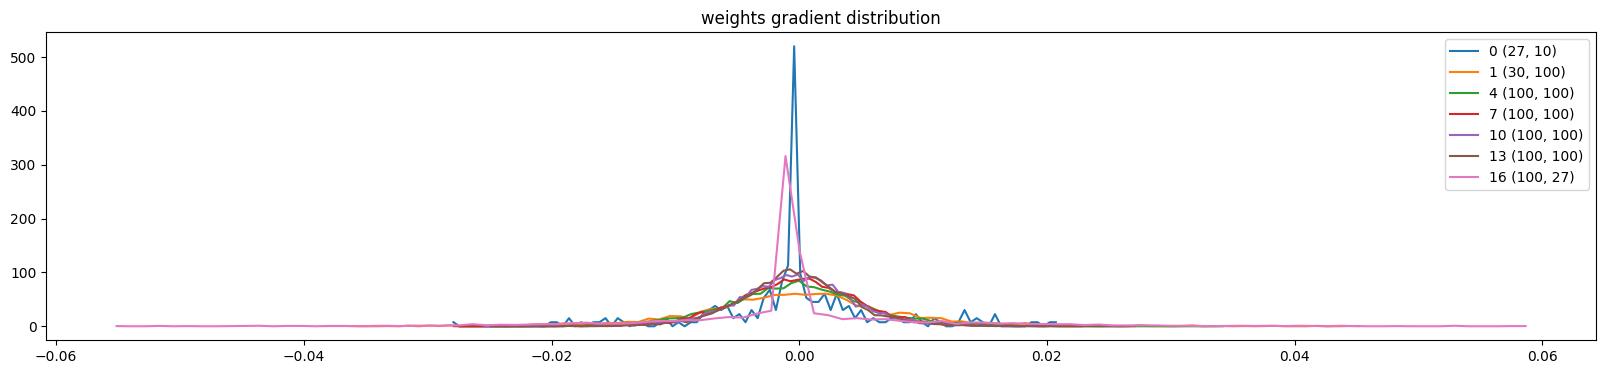

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

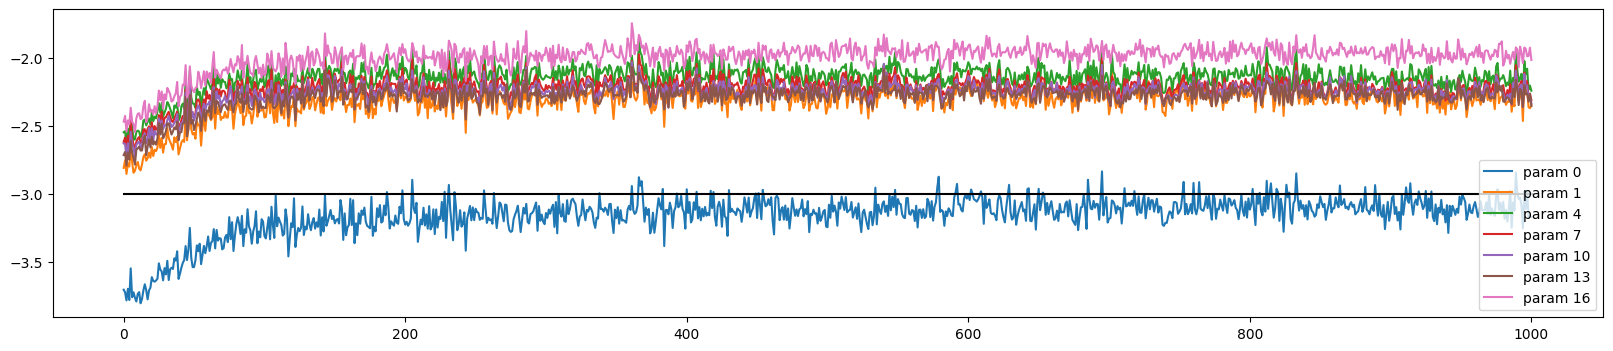

In [46]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.16284441947937
val 2.1616599559783936


In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

narpavxqthila.
khi.
mrixrthiya.
kansha.
jarhuthanpesarthirqhi.
nelani.
tchaiivdas.
hin.
dham.
poin.
qsijuna.
lilaa.
vidhi.
watthugijaryxi.
jithupirudhina.
tai.
athina.
hashra.
aras.
bhariksya.
